<a href="https://colab.research.google.com/github/am28012/atharvamore_github.io/blob/main/Samsung_Sales_Forecasting_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr


In [5]:
df = pd.read_csv('/content/Samsung_cleaned.csv')
print(df.head())
print(df.info())

   Year Quarter  Product Model 5G Capability  Units Sold  Revenue ($)  \
0  2019      Q1     Galaxy S10            No       26396      4212951   
1  2019      Q1  Galaxy Note10            No       25671      7240266   
2  2019      Q1     Galaxy S20            No       16573     25608332   
3  2019      Q1  Galaxy Note20            No        7177     21984416   
4  2019      Q1     Galaxy S21            No       45633     16342438   

   Market Share (%)  Regional 5G Coverage (%)  5G Subscribers (millions)  \
0              1.04                     57.36                      39.55   
1              2.82                     85.80                      42.58   
2             -0.03                     47.02                       3.78   
3              0.84                     25.70                      23.41   
4              2.36                     89.13                      44.43   

   Avg 5G Speed (Mbps)  Preference for 5G (%)                Region  
0               293.10            

In [7]:
print(df.describe())

              Year    Units Sold   Revenue ($)  Market Share (%)  \
count  1000.000000   1000.000000  1.000000e+03       1000.000000   
mean   2021.456000  32842.990000  3.019733e+07          3.723570   
std       1.700281  16039.770572  1.837941e+07          1.991108   
min    2019.000000   5309.000000  2.987436e+06         -0.490000   
25%    2020.000000  19327.250000  1.460749e+07          2.635000   
50%    2021.000000  33689.000000  2.801200e+07          3.760000   
75%    2023.000000  43911.000000  4.180391e+07          5.282500   
max    2024.000000  64883.000000  8.426494e+07          6.950000   

       Regional 5G Coverage (%)  5G Subscribers (millions)  \
count               1000.000000                1000.000000   
mean                  66.889720                  30.152080   
std                   19.254095                  14.537781   
min                   25.340000                  -0.890000   
25%                   50.400000                  18.412500   
50%            

EDA ANALYSIS 


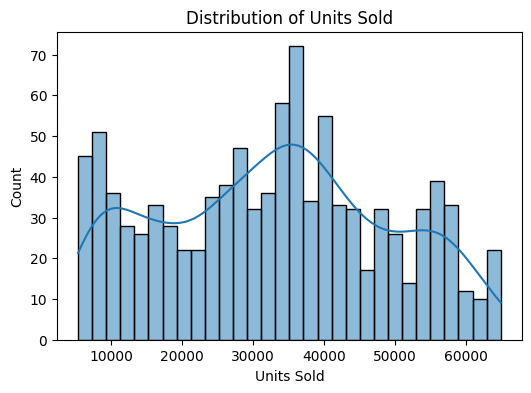

In [12]:
print(f"EDA ANALYSIS ")
plt.figure(figsize=(6,4))
sns.histplot(df['Units Sold'] , bins = 30 , kde = True)
plt.title("Distribution of Units Sold")
plt.show()

 Sales trends across categorical features


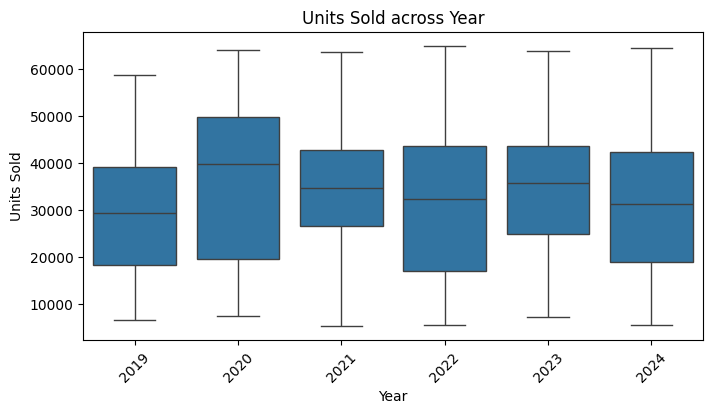

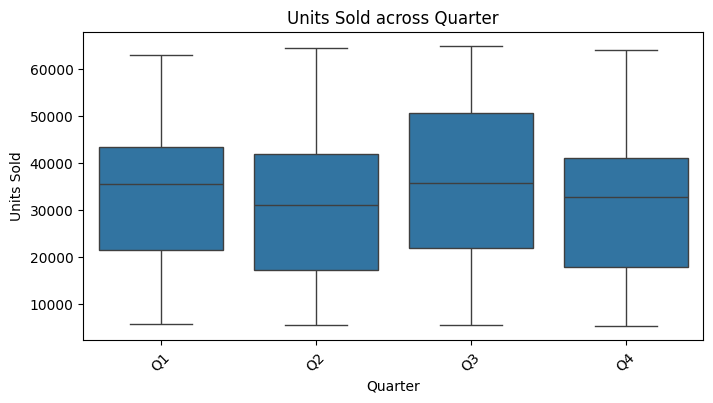

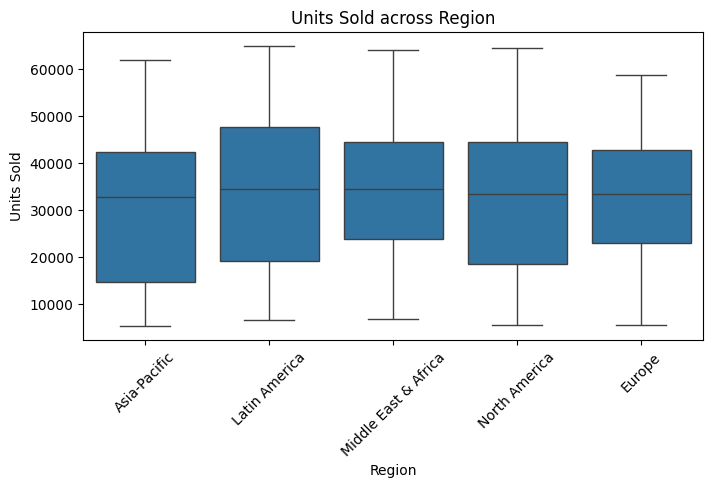

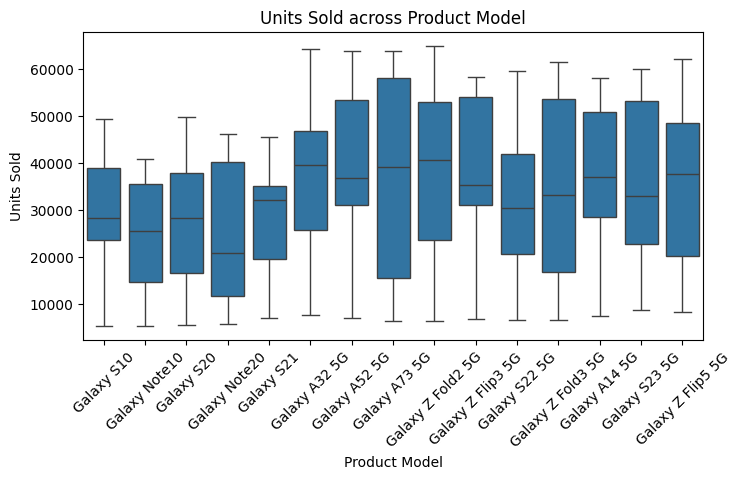

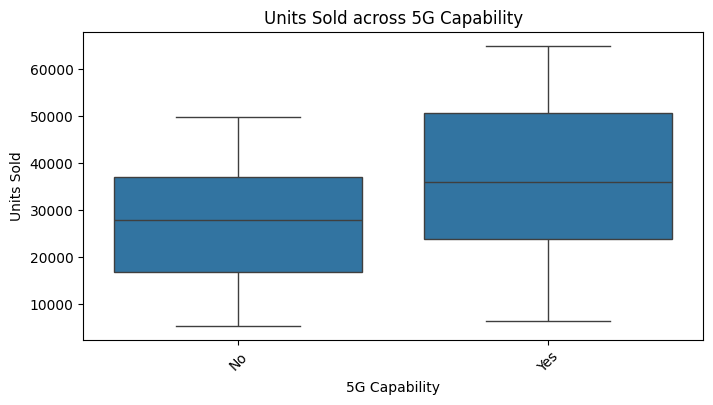

In [14]:
print(f" Sales trends across categorical features")
for col in ['Year', 'Quarter', 'Region', 'Product Model', '5G Capability']:
  plt.figure(figsize=(8,4))
  sns.boxplot(x=col, y='Units Sold', data=df)
  plt.xticks(rotation=45)
  plt.title(f"Units Sold across {col}")
  plt.show()



Correlation Matrix


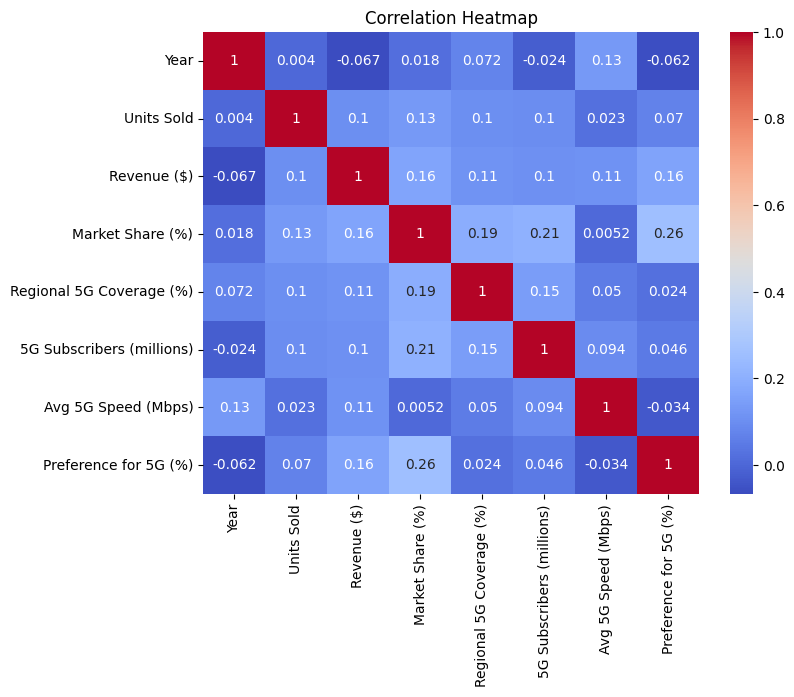

In [16]:
print(f"Correlation Matrix")
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [20]:
print(f"Pearson Test")
corrs = df.corr(numeric_only=True)['Units Sold'].sort_values(ascending=False)
print("\nCorrelation with Units Sold:\n",corrs)

Pearson Test

Correlation with Units Sold:
 Units Sold                   1.000000
Market Share (%)             0.130647
Regional 5G Coverage (%)     0.103005
Revenue ($)                  0.101168
5G Subscribers (millions)    0.099676
Preference for 5G (%)        0.070199
Avg 5G Speed (Mbps)          0.022837
Year                         0.003983
Name: Units Sold, dtype: float64


In [33]:
print(f"ANOVA TEST")
import scipy.stats as stats
anova_region = stats.f_oneway(*[group['Units Sold'].values for name, group in df.groupby('Region')])
print("ANOVA Region p-value:", anova_region.pvalue)

ANOVA TEST
ANOVA Region p-value: 0.4855138075987895


In [35]:
print(f"Chi Square Test ")
sales_bin = pd.qcut(df['Units Sold'], q=4 , labels=False)
for col in ['Region', 'Quarter', 'Product Model', '5G Capability']:
  contingency_table = pd.crosstab(df[col], sales_bin)
  chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
  print(f"{col} p-value:", p)


Chi Square Test 
Region p-value: 0.13106211822251357
Quarter p-value: 1.0432798920351732e-05
Product Model p-value: 3.502824283066802e-17
5G Capability p-value: 4.8181698293146186e-17


In [49]:
print(f"Feature Engineering")
df['Revenue_per_unit'] = df['Revenue ($)'] / df['Units Sold']
df['5G_Intensity'] = df['Regional 5G Coverage (%)'] * df['Preference for 5G (%)']
df['Time_Index'] = df['Year'].astype(str) + "_" + df['Quarter'].astype(str)
from sklearn.preprocessing import LabelEncoder, StandardScaler
cat_cols = ['Region', 'Quarter', 'Product Model', '5G Capability', 'Time_Index']
encoder = LabelEncoder()
for col in cat_cols:
  df[col] = encoder.fit_transform(df[col])

from sklearn.model_selection import train_test_split
X = df.drop(columns=['Units Sold'])
y = df['Units Sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lr = lin_reg.predict(X_test_scaled)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

xgb_reg = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)

Feature Engineering


In [60]:
print(f"Model Evaluation")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix , classification_report

def evaluate_model(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  return mse, mae, r2
  print(f"{model_name} = RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

evaluate_model(y_test, y_pred_lr)
evaluate_model(y_test, y_pred_rf)
evaluate_model(y_test, y_pred_xgb)


Model Evaluation


(2433617.75, 362.69390869140625, 0.9907752871513367)

In [63]:
print(f"Linear Regression Model Evaluation")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mse_lr, mae_lr, r2_lr = evaluate_model(y_test, y_pred_lr)

print(f"RMSE: {mse_lr**0.5:.2f}")
print(f"MAE: {mae_lr:.2f}")
print(f"R²: {r2_lr:.2f}")

Linear Regression Model Evaluation
RMSE: 11841.91
MAE: 8895.67
R²: 0.47


In [68]:
print(f"xgb Evaluation")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mse_xgb, mae_xgb, r2_xgb = evaluate_model(y_test, y_pred_rf)

print(f"RMSE: {mse_xgb**0.5:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R²: {r2_xgb:.2f}")

random Forest Regressor Evaluation
RMSE: 2008.89
MAE: 1133.91
R²: 0.98


In [79]:
print(f" random Forest RegressorEvaluation")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mse_rf, mae_rf, r2_rf = evaluate_model(y_test, y_pred_rf)

print(f"RMSE: {mse_rf**0.5:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

 random Forest RegressorEvaluation
RMSE: 2008.89
MAE: 1133.91
R²: 0.98


Feature Importances


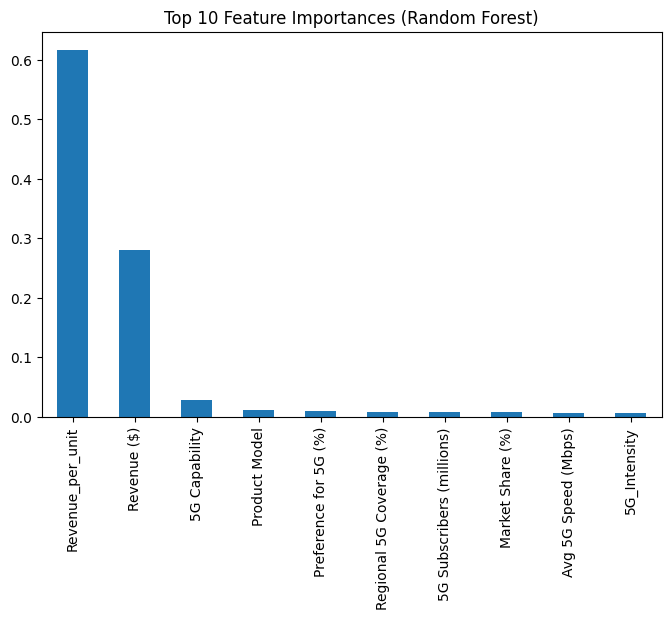

In [80]:
print(f"Feature Importances")
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind='bar')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()